In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Loading data

- using librosa library to load wav sounds

# **Computing SFFT**

## - creating function compute_rfft for rfft

rfft — це реальне швидке перетворення Фур'є
(Real Fast Fourier Transform), спеціальна версія FFT, яка працює тільки з реальними сигналами і повертає тільки позитивні частоти.

#### Формула для rFFT (реального швидкого перетворення Фур'є)

Оскільки $x_n$​ є реальним сигналом, його спектр симетричний:
$$X_{N−k}=X_k∗$$


де $X_k^∗$​ — це комплексне спряжене $X_k$​.

Отже, нам достатньо обчислювати лише першу половину спектру, тобто:
$$Xk=\sum_{n=0}^{N−1}x_ne^{−j2\pi kn/N},k=0,1,...,N/2$$

Тут:

- $k$ змінюється тільки від $0$ до $N/2$.

- Це означає, що rFFT повертає $(N/2 + 1)$ значень (бо враховується і частота Nyquist $f_s/2$).

## - creating function compute_sfft for sfft

SFFT — це локалізоване у часі перетворення Фур'є, яке використовується для аналізу незмінних у часі сигналів.

#### Формула для SFFT (Short-Time Fourier Transform)

$X(t,f)=n=\sum_{n=−\infty}^\infty​x(n)w(n−t)e^{−j2 \pi fn}$
де:

- $x(n)$ — дискретний вхідний сигнал.

- $w(n−t)$ — віконна функція (наприклад, Hann або Hamming).

- $e^{−j2 \pi fn}$ — комплексний експоненційний множник (база Фур'є).

- $X(t,f)$ — спектр сигналу у часово-частотному просторі.

У матричному вигляді:

- Результат SFFT — це матриця $X(T,F)$, де:

    - $T$ — кількість часових вікон.

    - $F$ — кількість частотних компонент.

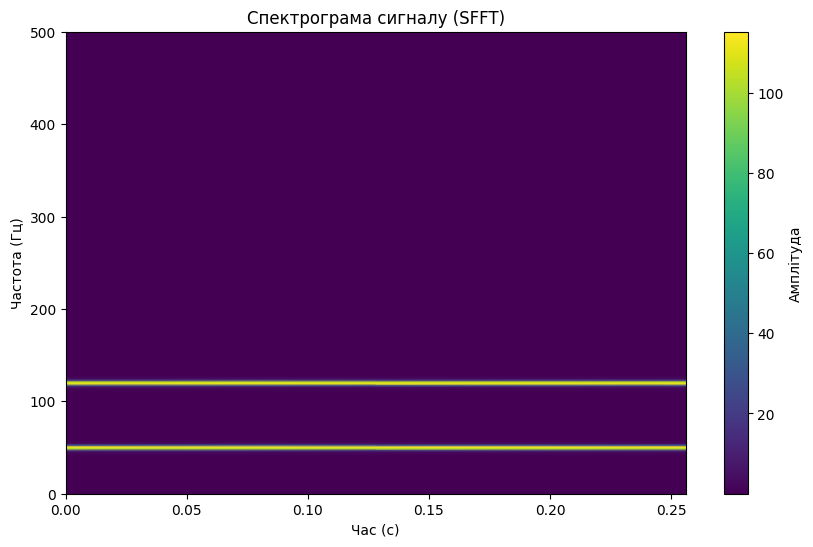

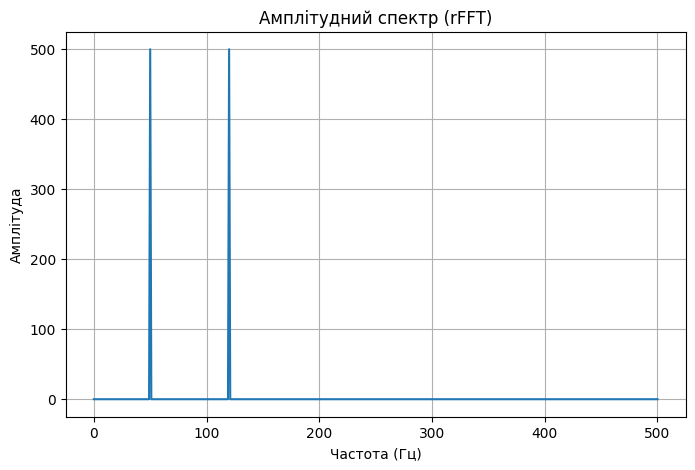

In [ ]:
def compute_rfft(signal, fs):
    """
    Реалізація реального швидкого перетворення Фур'є (rFFT).
    
    Параметри:
    - signal: np.array - вхідний сигнал.
    - fs: int - частота дискретизації (Hz).
    
    Повертає:
    - freqs: np.array - частоти
    - spectrum: np.array - спектральні коефіцієнти
    """
    N = len(signal)
    spectrum = np.zeros(N // 2 + 1, dtype=complex)
    for k in range(N // 2 + 1):
        for n in range(N):
            spectrum[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
    
    freqs = np.fft.rfftfreq(N, d=1/fs)
    return freqs, spectrum

def compute_sfft(signal, fs, window='hann', nperseg=512, noverlap=256, plot=True):
    """
    Реалізація короткочасного перетворення Фур'є (SFFT).
    
    Параметри:
    - signal: np.array - вхідний сигнал.
    - fs: int - частота дискретизації (Hz).
    - window: str - тип вікна (за замовчуванням 'hann').
    - nperseg: int - розмір вікна (кількість семплів).
    - noverlap: int - крок між вікнами.
    - plot: bool - якщо True, будує спектрограму та амплітудний спектр.
    
    Повертає:
    - f: np.array - частоти (SFFT)
    - t: np.array - часові відмітки (SFFT)
    - Zxx: np.array - спектральні коефіцієнти (SFFT)
    - freqs: np.array - частоти (rFFT)
    - spectrum: np.array - спектральні коефіцієнти (rFFT)
    """
    step = nperseg - noverlap
    num_windows = (len(signal) - noverlap) // step
    
    if window == 'hann':
        win = np.hanning(nperseg)
    else:
        win = np.ones(nperseg)
    
    f = np.fft.rfftfreq(nperseg, d=1/fs)
    t = np.arange(num_windows) * step / fs
    
    Zxx = np.zeros((len(f), len(t)), dtype=complex)
    for i in range(num_windows):
        segment = signal[i * step : i * step + nperseg] * win
        Zxx[:, i] = compute_rfft(segment, fs)
    
    freqs, spectrum = compute_rfft(signal, fs)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
        plt.colorbar(label='Амплітуда')
        plt.ylabel('Частота (Гц)')
        plt.xlabel('Час (с)')
        plt.title('Спектрограма сигналу (SFFT)')
        plt.show()
        
        plt.figure(figsize=(8, 5))
        plt.plot(freqs, np.abs(spectrum))
        plt.xlabel('Частота (Гц)')
        plt.ylabel('Амплітуда')
        plt.title('Амплітудний спектр (rFFT)')
        plt.grid()
        plt.show()
    
    return f, t, Zxx, freqs, spectrum

# Приклад використання
fs = 1000  # Частота дискретизації (Гц)
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)

f, t, Zxx, freqs, spectrum = compute_sfft(signal, fs)


# Computing PCA

PCA (Principal Component Analysis) — це метод зменшення вимірності даних, який дозволяє перетворити набір змінних (фіч) у новий набір змінних, який називається головними компонентами (principal components). Це робиться таким чином, щоб нові змінні були лінійно незалежними і містили найбільшу кількість варіативності (інформації) з початкових змінних. Процес може бути розділений на кілька етапів.

**Формули**:

- Центрування даних:

    $X_{центр}=X−\mu$

де $\mu$ — середнє значення по кожній ознаці.

- Ковариаційна матриця:

    $C=\frac{1}{n−1}X_{центр}^TX_{центр}$

    Власні значення та власні вектори:

    $Cv=λv$

для кожного $i$, де $v_i$​ — власний вектор, $λ_i$​ — відповідне власне значення.

- Перетворення даних:

    $X′=XV_k$​

де $V_k$​ — матриця з вибраними власними векторами (головними компонентами).

**Вибір кількості головних компонент**:

Якщо ви хочете зберегти певну частку варіативності даних, можна вибрати кількість компонент, яка покриває, наприклад, $95%$ загальної дисперсії. Це робиться на основі сумарних власних значень:

$$\frac{\sum_{i=1}^k λ_i}{\sum_{i=1}^m λ_i}$$


де $λ_i$​ — власні значення, а $k$ — кількість вибраних компонент.

**Як це працює на практиці**:

1. Центруєте дані (віднімаєте середнє для кожної змінної).

2. Обчислюєте ковариаційну матрицю, щоб зрозуміти, як змінні пов'язані одна з одною.

3. Знаходите напрямки (головні компоненти), по яких дані найбільше розподіляються.

4. Вибираєте кілька головних компонент, які зберігають більшість варіативності.

5. Проектуєте дані в нову систему координат.

In [ ]:
def pca(X, num_components):
    """
    Реалізація PCA без використання сторонніх бібліотек.

    Параметри:
    - X: np.array - матриця даних, розміри (n_samples, n_features)
    - num_components: int - кількість головних компонент, які ми хочемо зберегти.

    Повертає:
    - X_pca: np.array - перетворені дані в новому просторі головних компонент.
    - components: np.array - головні компоненти (власні вектори).
    - explained_variance: np.array - пояснена дисперсія (власні значення).
    """
    # 1. Центрування даних (віднімання середнього значення по кожній ознаці)
    mean = np.mean(X, axis=0)  # Середнє значення по кожній ознаці
    X_centered = X - mean  # Центровані дані

    # 2. Обчислення ковариаційної матриці
    covariance_matrix = np.cov(X_centered, rowvar=False)  # ковариація по ознаках

    # 3. Обчислення власних значень та власних векторів
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # 4. Сортування власних значень та відповідних власних векторів за спаданням
    sorted_indices = np.argsort(eigenvalues)[::-1]  # індекси від найбільшого до найменшого
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    # 5. Вибір перших num_components компонент (головних компонент)
    components = eigenvectors_sorted[:, :num_components]  # Вибір перших компонент
    explained_variance = eigenvalues_sorted[:num_components]  # Пояснена дисперсія для вибраних компонент

    # 6. Проекція даних на нові головні компоненти
    X_pca = X_centered.dot(components)  # Проекція на головні компоненти

    return X_pca, components, explained_variance

# Приклад використання:
# Створимо матрицю даних (10 спостережень, 5 ознак)
X = Zxx.T

# Застосуємо PCA, зберігаючи 2 головні компоненти
X_pca, components, explained_variance = pca(X, num_components=5)


Перетворені дані в новому просторі головних компонент:
 [[ 1.91884188e-01 -1.31212153e-01  6.67756219e-02  3.85868328e-01
   3.02917762e-02]
 [ 2.31559466e-01 -2.65168692e-01  1.84102549e-01 -7.49202188e-02
  -6.53796185e-02]
 [-1.25163620e-01 -2.41722834e-01 -7.56876489e-03 -9.95302181e-02
   2.23099546e-01]
 [ 5.39419734e-01  1.91359731e-01 -5.18326352e-02 -2.08885616e-01
  -2.00806683e-01]
 [-5.74798723e-01 -3.19903462e-01 -8.78100194e-02  1.21947969e-01
  -6.11923146e-02]
 [-3.18059564e-01  6.42182056e-01  8.07707334e-02  2.58790974e-01
  -5.92733834e-02]
 [-4.68521820e-01 -4.82722689e-02 -3.38984227e-01 -2.08370435e-01
  -1.17467109e-01]
 [ 3.22240159e-01  3.02564910e-01 -3.23573947e-01 -5.68792885e-02
   2.27131865e-01]
 [-2.24776829e-01  1.40257543e-01  4.78577497e-01 -2.56435393e-01
   7.17976613e-02]
 [ 4.26217008e-01 -2.70084831e-01 -4.56807839e-04  1.38413899e-01
  -4.82017399e-02]]

Головні компоненти (власні вектори):
 [[-0.65254551 -0.4463658  -0.24480212 -0.48723993 -0.2

## Щоб перейти до Gaussian Discriminant Analysis (GDA) після зменшення розмірності з PCA, потрібно виконати наступні кроки:

1. Підготовка даних для GDA: Після застосування PCA, ви отримуєте нові зменшені вектори ознак (матриця X_pca). Тепер вам потрібно підготувати ці дані для застосування GDA. Ви повинні мати емоції, до яких належать ваші зразки даних, оскільки GDA — це метод для класифікації.

2. Навчання GDA: У GDA передбачається, що кожний клас (емоція) має нормальний розподіл з окремими параметрами (середнє та ковариаційна матриця) для кожного класу. Вам потрібно буде навчити модель GDA, оцінюючи ці параметри для кожного класу на основі зменшеного набору ознак.

3. Прогнозування GDA: Після навчання ви зможете використовувати GDA для прогнозування емоції для нових, невідомих даних.

# Кроки реалізації GDA після PCA

- Навчання моделі GDA: Для кожного класу (емоції) GDA оцінює середнє значення та ковариаційну матрицю для зменшених ознак.

**Формули GDA**:

- Для кожного класу $y_k$​, середнє $\mu_k$​ і ковариаційна матриця $Σk$​ обчислюються як:
    
$$\mu_k=\frac{1}{N_k} \sum_{i\in C_k}X_i$$

де $N_k$​ — кількість зразків у класі $y_k$​, а $C_k$​ — зразки, що належать класу $y_k$​.

$$\sum_k=\frac{1}{N_k-1} \sum_{i \in C_k}(X_i−\mu_k)(X_i−\mu_k)^T$$


де $X_i$​ — вектор ознак зменшеної розмірності після PCA.

Для класифікації нових зразків, використовується правило Байєса. Потрібно обчислити ймовірність для кожного класу, і передбачити клас, який має максимальну ймовірність.

**Логарифм ймовірності класу для зразка $X$:**

$$logP(y_k​∣X)=−\frac{1}{2}​(X−μ_k​^)T \sum^{-1}(X−μ_k​)−\frac{1}{2}​log∣\sum∣+logP(y_k​)$$

In [ ]:
import numpy as np

# Функція для навчання GDA
def gda_train(X, y):
    """
    Навчання GDA для класифікації.
    X - матриця зменшених ознак (samples x features)
    y - вектор міток класів (sample_labels)
    
    Повертає:
    - mu: середнє для кожного класу (C x features)
    - sigma: спільна ковариаційна матриця
    - priors: ймовірності класів
    """
    classes = np.unique(y)  # Унікальні класи
    mu = np.zeros((len(classes), X.shape[1]))  # Матрична форма для середніх
    sigma = np.zeros((X.shape[1], X.shape[1]))  # Ковариаційна матриця
    priors = np.zeros(len(classes))  # Ймовірності класів

    # Оцінка середнього та ковариаційної матриці для кожного класу
    for i, c in enumerate(classes):
        X_c = X[y == c]  # Вибір зразків для класу c
        mu[i] = np.mean(X_c, axis=0)  # Оцінка середнього для класу c
        sigma += np.cov(X_c.T) * len(X_c)  # Оцінка ковариаційної матриці (сумування по класах)
        priors[i] = len(X_c) / len(X)  # Оцінка апріорної ймовірності

    sigma /= len(X)  # Середнє по всіх класах

    return mu, sigma, priors


# Функція для класифікації GDA
def gda_predict(X, mu, sigma, priors):
    """
    Класифікація нових зразків за допомогою GDA.
    X - матриця зменшених ознак (samples x features)
    mu - середнє для кожного класу
    sigma - спільна ковариаційна матриця
    priors - ймовірності класів
    
    Повертає:
    - y_pred: передбачені мітки класів
    """
    num_samples = X.shape[0]
    num_classes = mu.shape[0]
    y_pred = np.zeros(num_samples)

    # Обчислення логарифмів ймовірностей для кожного класу
    for i in range(num_samples):
        log_likelihoods = np.zeros(num_classes)
        for j in range(num_classes):
            diff = X[i] - mu[j]
            log_likelihood = -0.5 * np.dot(np.dot(diff, np.linalg.inv(sigma)), diff.T) \
                            - 0.5 * np.log(np.linalg.det(sigma)) \
                            + np.log(priors[j])
            log_likelihoods[j] = log_likelihood

        y_pred[i] = np.argmax(log_likelihoods)  # Вибір класу з найвищою ймовірністю

    return y_pred


# Приклад використання:

# X_pca - зменшені вектори ознак після PCA (samples x features)
# y - вектор міток класів для кожного запису (емоції)

# Навчання GDA
mu, sigma, priors = gda_train(X_pca, y)

# Класифікація нових зразків
y_pred = gda_predict(X_new_pca, mu, sigma, priors)

# Виведення результатів
print("Передбачені мітки класів:", y_pred)


## Support Vector Mchine algorithm